In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

gemini_api_key=os.getenv("GEMINI_API_KEY")
LANGCHAIN_API_KEY=os.getenv("LANGCHAIN_API_KEY")

os.environ["GEMINI_API_KEY"] = gemini_api_key
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

In [2]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash",api_key=gemini_api_key)
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001",google_api_key=gemini_api_key)

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
urls =  [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100, chunk_overlap=50)

doc_splits = text_splitter.split_documents(docs_list)

vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings
)

retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
from langchain.tools.retriever import create_retriever_tool
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

tools = [retriever_tool]

Let's look into the retriever grader

In [6]:
from langchain_core.prompts  import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

class GradeDocuments(BaseModel):
    """Binary Score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

c:\AI\langgraph-end-to-end\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3667: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
structured_llm_grader = llm.with_structured_output(GradeDocuments)

In [8]:
system = """You are a grader checking if a document is relevant to a user’s question.The check has to be done very strictly..  
If the document has words or meanings related to the question, mark it as relevant.  
Give a simple 'yes' or 'no' answer to show if the document is relevant or not."""
    
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [9]:
my_retrieval_grader = grade_prompt | structured_llm_grader
question = "what is ai agent?"

In [10]:

docs = retriever.get_relevant_documents(question)


C:\Users\Parth\AppData\Local\Temp\ipykernel_21236\4110481353.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


In [11]:
doc_txt = docs[2].page_content
doc_txt

'Agent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:'

In [12]:
print(my_retrieval_grader.invoke({"document":doc_txt,"question":question}))

binary_score='yes'


In [13]:
question="who is neel patel?"

In [14]:
print(my_retrieval_grader.invoke({"document":doc_txt,"question": question}))

binary_score='no'


let's look into the data generation

In [15]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt = hub.pull("rlm/rag-prompt")

In [16]:
prompt.pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [17]:
rag_chain = prompt | llm

In [18]:
question = "what is a AI agent?"

In [19]:
generation = rag_chain.invoke({"context": docs,"question":question})
generation.content

'An AI agent is a system using a large language model (LLM) as its core, complemented by planning, memory (short-term and long-term), and tool use capabilities.  It breaks down complex tasks into smaller subgoals, learns from its actions, and utilizes external APIs for additional information.  Examples include AutoGPT, GPT-Engineer, and BabyAGI.'

Hallucination Grader

In [20]:
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no' "
    )

In [21]:
structured_llm_grader = llm.with_structured_output(GradeHallucinations) 

In [22]:
# Prompt
system = """You are a grader checking if an LLM generation is grounded in or supported by a set of retrieved facts.  
Give a simple 'yes' or 'no' answer. 'Yes' means the generation is grounded in or supported by a set of retrieved the facts and 'no'  means the generation is not grounded in or not supported by a set of retrieved the facts """
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

In [23]:
hallucination_grader = hallucination_prompt | structured_llm_grader

In [24]:
print(hallucination_grader.invoke({"documents":docs,"generation":generation}))

binary_score='yes'


Answer Grader

In [25]:
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score:str = Field(
        description = "Answer addresses the question, 'yes' or 'no'"
    )

structured_llm_grader = llm.with_structured_output(GradeAnswer)
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)
answer_grader = answer_prompt | structured_llm_grader
print(answer_grader.invoke({"question":question,"generation":generation}))

binary_score='yes'


Question Re-writer

In [26]:
system = """You are a question re-writer that converts an input question into a better optimized version for vector store retrieval document.  
You are given both a question and a document.  
- First, check if the question is relevant to the document by identifying a connection or relevance between them.  
- If there is a little relevancy, rewrite the question based on the semantic intent of the question and the context of the document.  
- If no relevance is found, simply return this single word "question not relevant." dont return the entire phrase 
Your goal is to ensure the rewritten question aligns well with the document for better retrieval."""
     
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human","""Here is the initial question: \n\n {question} \n,
             Here is the document: \n\n {documents} \n ,
             Formulate an improved question. if possible other return 'question not relevant'."""
        ),
    ]
)
question_rewriter = re_write_prompt | llm | StrOutputParser()

In [27]:
question="who is a current indian prime minister?"

question_rewriter.invoke({"question":question,"documents":docs})

'question not relevant'

In [28]:
from typing import List
from typing_extensions import TypedDict
class AgentState(TypedDict):
    question: str
    generation: str
    documents: List[str]
    filter_documents: List[str]
    unfilter_documents: List[str]

In [29]:
def retrieve(state:AgentState):
    print("----RETRIEVE----")
    question = state["question"]
    documents = retriever.get_relevant_documents(question)
    return {"documents":documents,"question":question}

In [30]:
def grade_documents(state:AgentState):
    print("----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----")
    question = state['question']
    documents = state['documents']
    
    filtered_docs = []
    unfiltered_docs = []
    for doc in documents:
        score=my_retrieval_grader.invoke({"question":question, "document":doc})
        grade=score.binary_score
        
        if grade=='yes':
            print("----GRADE: DOCUMENT RELEVANT----")
            filtered_docs.append(doc)
        else:
            print("----GRADE: DOCUMENT NOT RELEVANT----")
            unfiltered_docs.append(doc)
    if len(unfiltered_docs)>1:
        return {"unfilter_documents": unfiltered_docs,"filter_documents":[], "question": question}
    else:
        return {"filter_documents": filtered_docs,"unfilter_documents":[],"question": question}

In [31]:
def decide_to_generate(state:AgentState):
    print("----ACCESS GRADED DOCUMENTS----")
    state["question"]
    unfiltered_documents = state["unfilter_documents"]
    filtered_documents = state["filter_documents"]
    print("Available keys in state:", state.keys())
    if unfiltered_documents:
        print("----ALL THE DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY----")
        return "transform_query"
    if filtered_documents:
        print("----DECISION: GENERATE----")
        return "generate"

In [32]:
def generate(state:AgentState):
    print("----GENERATE----")
    question=state["question"]
    documents=state["documents"]
    
    generation = rag_chain.invoke({"context": documents,"question":question})
    return {"documents":documents,"question":question,"generation":generation}

In [33]:
from langgraph.graph import END, StateGraph, START
def transform_query(state:AgentState):
    question=state["question"]
    documents=state["documents"]
    
    print(f"this is my document{documents}")
    response = question_rewriter.invoke({"question":question,"documents":documents})
    print(f"----RESPONSE---- {response}")
    if response == 'question not relevant':
        print("----QUESTION IS NOT AT ALL RELEVANT----")
        return {"documents":documents,"question":question,"generation":"question was not at all relevant"}
    else:   
        return {"documents":documents,"question":response}


In [34]:
def decide_to_generate_after_transformation(state:AgentState):
    question=state["question"]
    
    if question=="question not relevant":
        return "query_not_at_all_relevant"
    else:
        return "Retriever"

In [35]:
import pprint
def grade_generation_vs_documents_and_question(state:AgentState):
    print("---CHECK HELLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke({"documents":documents,"generation":generation})
    grade = score.binary_score
    #Check hallucinations
    if grade == 'yes':
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        
        print("---GRADE GENERATION vs QUESTION ---")

        score = answer_grader.invoke({"question":question,"generation":generation})

        grade = score.binary_score

        if grade=='yes':
            print("---DECISION: GENERATION ADDRESS THE QUESTION ---")
            return "useful"
        else:
            print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---TRANSFORM QUERY")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---TRANSFORM QUERY")
        "not useful"

In [36]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

In [37]:
from langchain.schema import Document
def web_search(state:AgentState):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")

    question = state["question"]
    documents = state["documents"]

    #web search
    docs = web_search_tool.invoke({"query":question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {"documents": documents,"question":question}

In [38]:
def generate(state: AgentState):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    generation = rag_chain.invoke({"context": documents, "question": question})

    return {"documents":documents,"question":question,"generation":generation}

In [39]:
from typing import List
from typing_extensions import TypedDict
from langgraph.graph import START,END, StateGraph

workflow = StateGraph(AgentState)
workflow.add_node("Docs_Vector_Retrieve",retrieve)
workflow.add_node("Grading_Generated_Documents",grade_documents)
workflow.add_node("Content_Generator",generate)
workflow.add_node("Transform_User_Query",transform_query)


In [40]:
workflow.add_edge(START,"Docs_Vector_Retrieve")
workflow.add_edge("Docs_Vector_Retrieve","Grading_Generated_Documents")
workflow.add_conditional_edges("Grading_Generated_Documents",
                            decide_to_generate,
                            {
                            "generate": "Content_Generator",
                            "transform_query": "Transform_User_Query"
                            }
                            )
workflow.add_conditional_edges("Content_Generator",
                            grade_generation_vs_documents_and_question,
                            {
                            "useful": END,
                            "not useful": "Transform_User_Query",
                            }
                            )
workflow.add_conditional_edges("Transform_User_Query",
                decide_to_generate_after_transformation,
                {
                "Retriever":"Docs_Vector_Retrieve",
                "query_not_at_all_relevant":END
                }
                )

In [41]:
app = workflow.compile()

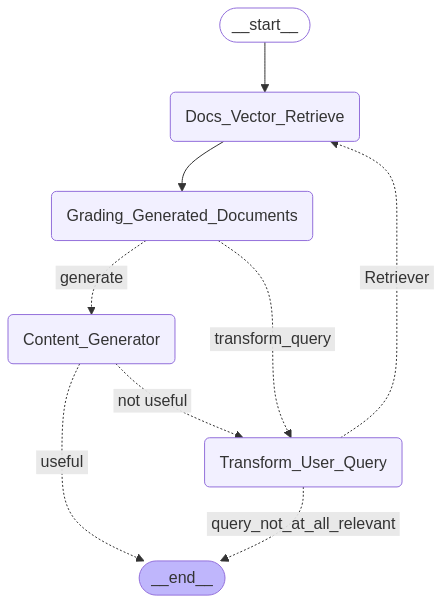

In [42]:
from IPython.display import Image, display # type: ignore
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [43]:
# inputs = {"question": "Explain how the different types of agent memory work?"}

In [44]:
# app.invoke(inputs)


In [45]:
inputs = {"question": "who is a first president of USA?"}

In [46]:
app.invoke(inputs)

----RETRIEVE----
----CHECK DOCUMENTS RELEVANCE TO THE QUESTION----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----GRADE: DOCUMENT NOT RELEVANT----
----ACCESS GRADED DOCUMENTS----
Available keys in state: dict_keys(['question', 'documents', 'filter_documents', 'unfilter_documents'])
----ALL THE DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY----
this is my document[Document(metadata={'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of promp

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 57
}
].


ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 55
}
]